In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import os
import xrft 
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41689,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:33175,Total threads: 4
Dashboard: /proxy/33425/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:42625,


## Load the along beam data

In [10]:
output = "002"
surface = xr.open_dataset(f"/g/data/nm03/ab8992/fullexpt-test/output{output}/surface.nc",decode_times = False)
u = xr.open_mfdataset(f"/g/data/nm03/ab8992/fullexpt-test/output{output}/u/*",decode_times = False).u
v = xr.open_mfdataset(f"/g/data/nm03/ab8992/fullexpt-test/output{output}/v/*",decode_times = False).v
e = xr.open_mfdataset(f"/g/data/nm03/ab8992/fullexpt-test/output{output}/e/*",decode_times = False).e
rho = xr.open_mfdataset(f"/g/data/nm03/ab8992/fullexpt-test/output{output}/rho/*",decode_times = False).rho
bathy = e.isel(time = 0,rho2_i = 0)

## Temporally filter outputs 

Filter in chunks of 10 tidal periods, staggered over 5 tidal periods. The overlaps will be averaged

i.e

i = 0
previous data = array of zeros
loop:
1. new data = Filter from `t=i` until `i+10` tidal periods
2. previous data = mean (previous data , new data)
3. save previous data somewhere
4. previous data = new data

Continue until we run out of complete 10 tidal period chunks of data. Then, save the last 5 tidal periods as the final part of time series.



In [5]:
def filter(field,freq,tol = 0.01):
    FIELD = xrft.fft(field,dim = "time")
    FIELD_filtered = FIELD.where(np.abs(np.abs(FIELD.freq_time) - freq) < tol,0)
    return np.real(xrft.ifft(FIELD_filtered,dim = "freq_time"))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


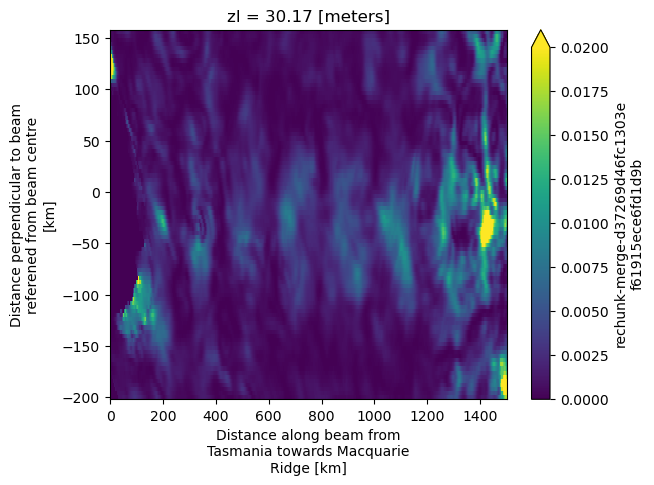

In [13]:
uf = filter(
    u.sel(
        time = slice(213361,213361 + m2 * 12)
        ).isel(zl = 5),
    m2f)
# vf = 
(uf**2 + vf**2).mean("time").plot(vmax = 0.02)

In [6]:
int(m2 * 12)

149

In [27]:
m2 = 360 / 28.984104 ## Period of m2 in hours
m2f = 1/ m2    ## Frequency of m2 in radians per hour
tol = 0.01
t0 = 213361
i = 0
u = u.fillna(0)
v = v.fillna(0)


averaging_window = int(12 * m2) ## this comes out to be 149.0472 hours, so close enough to a multiple of tidal periods

uf = filter(
    u.sel(
        time = slice(t0 + i,t0 + i + m2 * 12)
        ),
    m2f)
vf = filter(
    v.sel(
        time = slice(t0 + i,t0 + i + m2 * 12)
        ),
    m2f)

dux = u.mean("time").differentiate("xb")
dvy = v.mean("time").differentiate("yb")
duy = u.mean("time").differentiate("yb")
dvx = v.mean("time").differentiate("xb")

nstress_u = (uf * uf).mean("time")
nstress_v = (vf * vf).mean("time")
n_strain = dux - duy

shear = (uf * vf).mean("time")
shear_strain = duy + dvx

total = (nstress_u - nstress_v) * n_strain - shear * shear_strain
# total.integrate("zl").plot()


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


ValueError: 'time' not found in array dimensions ('yb', 'xb')

In [29]:
ke = (uf**2 + vf**2).integrate("zl").mean("time").persist()

2023-11-13 17:21:19,581 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 13.13 GiB -- Worker memory limit: 16.00 GiB
2023-11-13 17:21:20,044 - distributed.worker.memory - WARNING - Worker is at 55% memory usage. Resuming worker. Process memory: 8.88 GiB -- Worker memory limit: 16.00 GiB


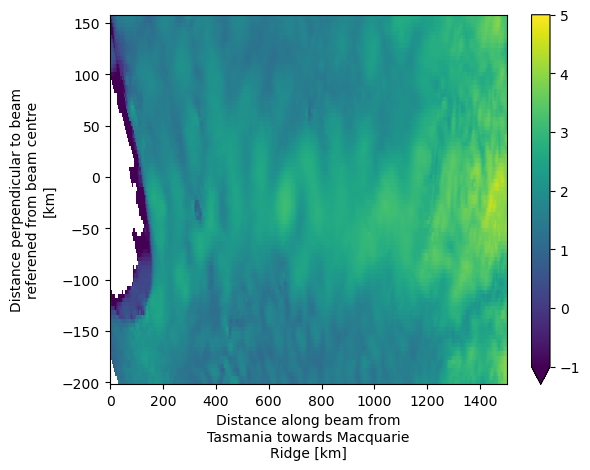

In [30]:
np.log(ke).plot(vmax = 5,vmin = -1)

In [20]:
uf

<xarray.DataArray 'rechunk-merge-5d41647d0fe4ba16cd18177763f53fbc' (time: 150,
                                                                    zl: 100,
                                                                    yb: 90,
                                                                    xb: 376)>
dask.array<real, shape=(150, 100, 90, 376), dtype=float64, chunksize=(150, 100, 10, 376), chunktype=numpy.ndarray>
Coordinates:
  * zl       (zl) float64 2.704 8.126 13.58 ... 5.236e+03 5.339e+03 5.443e+03
  * xb       (xb) float64 -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 -200.0 -196.0 -192.0 -188.0 ... 148.0 152.0 156.0
    lat      (yb, xb) float64 dask.array<chunksize=(10, 376), meta=np.ndarray>
    lon      (yb, xb) float64 dask.array<chunksize=(10, 376), meta=np.ndarray>
  * time     (time) float64 2.134e+05 2.134e+05 ... 2.135e+05 2.135e+05

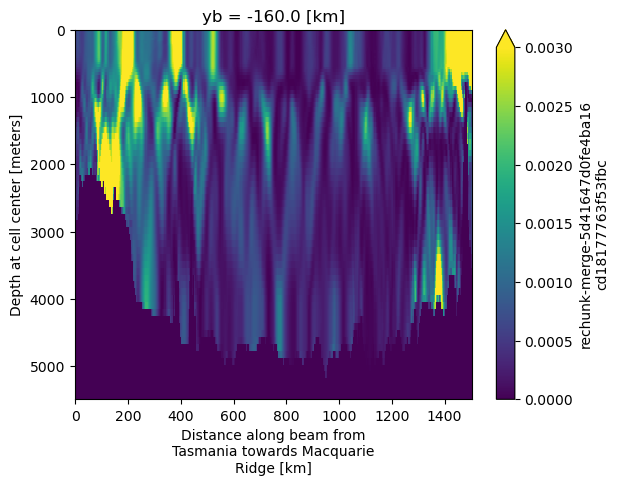

In [17]:
(uf**2).isel(yb = 10).mean("time").plot(vmax = 0.003)
## invert the y axis of existing plot
plt.gca().invert_yaxis()
# bathy.isel(yb = 10).plot()
